# Random Forest Classifier

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

## Loading the Processed Dataset

In [2]:
data = pd.read_csv("preprocessed.csv")

In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,...,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,...,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,...,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,14.6,8.9,11.0,24.0,13.0,...,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [4]:
data.shape

(145460, 25)

In [5]:
df=data.sample(n=12000)

In [6]:
df.shape

(12000, 25)

## Dividing the dataset into Independent and Dependent features

In [7]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
y = df["RainTomorrow"]

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y, random_state = 0)

In [9]:
y_train

79331     0
23603     0
52373     0
64843     1
96990     0
         ..
48655     1
31366     0
118671    0
41202     0
38226     0
Name: RainTomorrow, Length: 9600, dtype: int64

## Handling imbalanced dataset

<Axes: xlabel='RainTomorrow', ylabel='count'>

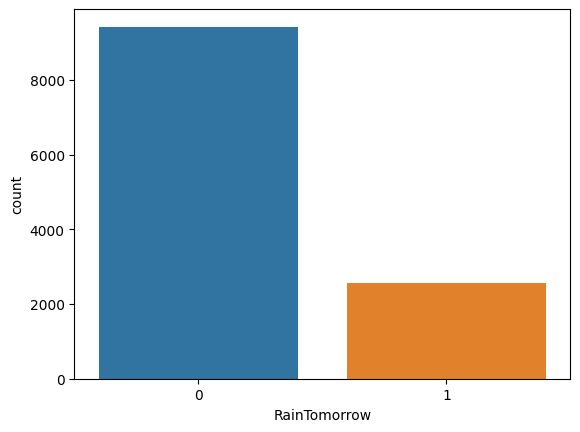

In [11]:
sns.countplot(x=df["RainTomorrow"])

In [12]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 7543, 1: 2057})
The number of classes after fit Counter({0: 7543, 1: 7543})


## Random Forest Classifier

In [13]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [14]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[1687  199]
 [ 211  303]]
0.8291666666666667
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1886
           1       0.60      0.59      0.60       514

    accuracy                           0.83      2400
   macro avg       0.75      0.74      0.74      2400
weighted avg       0.83      0.83      0.83      2400



0.7419899237056996

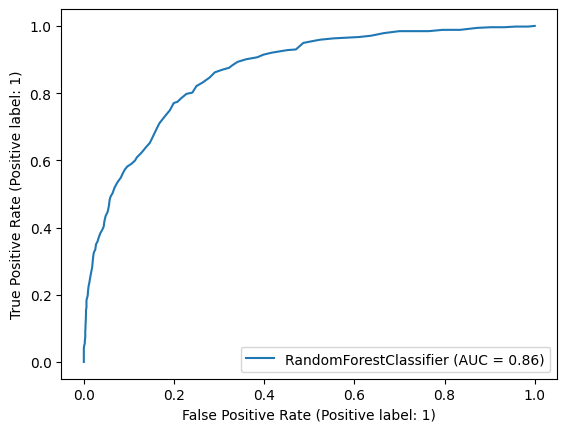

In [16]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None)

## Hyperparameter Optimization

In [17]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=200,stop=2000,num=10)]

# Number of features to consider at every split
max_features=['auto','sqrt', 'log2']

# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(10,1000,10)]

# Minimum number of samples required to split a node
min_samples_split=[2,5,10,14]

# Minimum number of samples required at each leaf node
min_samples_leaf=[1,2,4,6,8]

# Create the random grid
random_grid={'n_estimators':n_estimators,
            'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [ ]:
rf=RandomForestClassifier()
rf_randomCV=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=25,cv=3,verbose=2,random_state=100,n_jobs=-1)

### fit the randomized model
rf_randomCV.fit(X_train_res,y_train_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [24]:
rf_randomCV.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 120,
 'criterion': 'entropy'}

In [25]:
best_random_grid=rf_randomCV.best_estimator_

In [26]:
from sklearn.metrics import accuracy_score
y_pred = best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print('Accuracy score {}'.format(accuracy_score(y_test,y_pred)))
print('Classification report {}'.format(classification_report(y_test,y_pred)))

[[1690  207]
 [ 213  290]]
Accuracy score 0.825
Classification report               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1897
           1       0.58      0.58      0.58       503

    accuracy                           0.82      2400
   macro avg       0.74      0.73      0.73      2400
weighted avg       0.82      0.82      0.82      2400



## Saving the model to reuse it again

In [27]:
joblib.dump(rf_randomCV, "rf.pkl")

['rf.pkl']